In [420]:

from functools import cmp_to_key
import numpy as np
from sortedcontainers import SortedList, SortedKeyList

In [421]:
def generate_random_segments(n=10, min_intersections=2, coord_range=(0, 10)):
    # Создаем массив для хранения отрезков: (n, 2, 2), где каждый отрезок описывается двумя точками (x1,y1)-(x2,y2)
    segments = np.zeros((n, 2, 2))

    # Генерируем min_intersections пар пересекающихся отрезков
    for i in range(0, min_intersections * 2, 2):
        # Первый отрезок (горизонтальный или вертикальный)
        if np.random.choice([True, False]):
            # Горизонтальный отрезок
            y = np.random.uniform(*coord_range)
            x1, x2 = np.random.uniform(*coord_range, size=2)
            segments[i] = np.array([[x1, y], [x2, y]])
        else:
            # Вертикальный отрезок
            x = np.random.uniform(*coord_range)
            y1, y2 = np.random.uniform(*coord_range, size=2)
            segments[i] = np.array([[x, y1], [x, y2]])

        # Второй отрезок, гарантированно пересекающий первый
        if segments[i, 0, 0] == segments[i, 1, 0]:  # Первый вертикальный → второй горизонтальный
            x = segments[i, 0, 0]
            y = np.random.uniform(*coord_range)
            segments[i + 1] = np.array([[x - 2, y], [x + 2, y]])  # Пересекает первый
        else:  # Первый горизонтальный → второй вертикальный
            y = segments[i, 0, 1]
            x = np.random.uniform(*coord_range)
            segments[i + 1] = np.array([[x, y - 2], [x, y + 2]])  # Пересекает первый

    # Остальные отрезки — случайные
    for i in range(min_intersections * 2, n):
        segments[i] = np.random.uniform(*coord_range, size=(2, 2))

    return segments


In [422]:
class Segment:
    def __init__(self, label, nparray):
        self.label = label
        if (nparray[0, 1] > nparray[1, 1]) or ((nparray[0, 1] == nparray[1, 1]) and (nparray[0, 0] < nparray[1, 0])):
            self.start = nparray[0]
            self.end = nparray[1]
        else:
            self.start = nparray[1]
            self.end = nparray[0]

    start: np.ndarray
    end: np.ndarray

    def __eq__(self, other):
        return self.label == other.label

    def __neq__(self, other):
        return self.label != other.label

    def __repr__(self):
        return f"Segment {self.label}"

    def __hash__(self):
        return hash(self.label)



In [423]:
class Event:
    def __init__(self, x, y, start_in_this=None):
        if start_in_this is None:
            self.start_in_this = set()
        else:
            self.start_in_this = start_in_this
        self.y = y
        self.x = x

    def __str__(self):
        return f"x: {self.x} y: {self.y}"

    def __repr__(self):
        return self.__str__()

    def __lt__(self, other):
        return self.y > other.y or (self.y == other.y and
                                    self.x < other.x)

    def __eq__(self, other):
        return self.x == other.x and self.y == other.y

    def __ne__(self, other):
        return not self.__eq__(other)


In [424]:
def point_on_segment(segment, p: Event):
    ax, ay = segment.start
    bx, by = segment.end
    cx, cy = (p.x, p.y)

    cross_product = (bx - ax) * (cy - ay) - (by - ay) * (cx - ax)
    if abs(cross_product) > 1e-9:
        return False

    in_x = min(ax, bx) - 1e-9 <= cx <= max(ax, bx) + 1e-9
    in_y = min(ay, by) - 1e-9 <= cy <= max(ay, by) + 1e-9

    return in_x and in_y

In [425]:
def find_segment_x_by_current_y(seg, y):
    return seg.start[0] + (seg.end[0] - seg.start[0]) * (y - seg.start[1]) / (seg.end[1] - seg.start[1]) \
        if abs(seg.end[1] - seg.start[1]) > 1e-9 else seg.start[0]

In [426]:
def intersection_points(seg1, seg2):
    s1, e1 = seg1.start, seg1.end
    s2, e2 = seg2.start, seg2.end

    s1x, s1y = s1
    s2x, s2y = s2
    t_arr, u_arr = [], []
    v1 = e1 - s1
    v2 = e2 - s2
    v1x, v1y = v1[0], v1[1]
    v2x, v2y = v2[0], v2[1]
    result = list()
    # коллинеарны
    if abs(v1x * v2y - v1y * v2x) < 1e-9:
        if v1y != 0:
            t_arr.extend([(s2y - s1y) / v1y, (s2y - s1y + v2y) / v1y])
            u_arr.extend([0, 1])
        elif v1x != 0:
            t_arr.extend([(s2x - s1x) / v1x, (s2x - s1x + v2x) / v1x])
            u_arr.extend([0, 1])
        if v2y != 0:
            t_arr.extend([0, 1])
            u_arr.extend([(s1y - s2y) / v2y, (s1y - s2y + v1y) / v2y])
        elif v2x != 0:
            t_arr.extend([0, 1])
            u_arr.extend([(s1x - s2x) / v2x, (s1x - s2x + v1x) / v2x])
    elif v2y != 0:
        A = v2x / v2y
        B = s2x - s1x + A * (s1y - s2y)
        t = B / (v1x - A * v1y)
        t_arr.append(t)
        u_arr.append((s1y - s2y + v1y * t) / v2y)
    elif v1y != 0:
        A = v1x / v1y
        B = s1x - s2x + A * (s2y - s1y)
        u = B / (v2x - A * v2y)
        u_arr.append(u)
        t_arr.append((s2y - s1y + v2y * u) / v1y)
    for t, u in zip(t_arr, u_arr):
        if 0 <= t <= 1 and 0 <= u <= 1:
            point_t = s1 + t * v1
            point_u = s2 + u * v2
            if np.all(np.abs(point_t - point_u) < 1e-9):
                result.append(point_t)
    return result

SortedKeyList([], key=<functools.KeyWrapper object at 0x000001787B47C8E0>)
SortedKeyList([Segment 1], key=<functools.KeyWrapper object at 0x000001787B47C8E0>)
SortedKeyList([Segment 2, Segment 1], key=<functools.KeyWrapper object at 0x000001787B47C8E0>)
SortedKeyList([Segment 2, Segment 1, Segment 4], key=<functools.KeyWrapper object at 0x000001787B47C8E0>)
SortedKeyList([Segment 2, Segment 0, Segment 1, Segment 4], key=<functools.KeyWrapper object at 0x000001787B47C8E0>)
Segment 0 2 True
Segment 0 Segment 2 4.408556376102843
5.96850157946487 1.5599452033620265 -inf 0.0
Segment 0 Segment 0 0
5.96850157946487 5.96850157946487 -inf -inf
Segment 0 Segment 1 -1
5.96850157946487 5.96850157946487 -inf 0.0
Segment 0 Segment 4 -3.614814799931705
5.96850157946487 9.583316379396575 -inf 0.3225160398935025
Segment 1 2 True
Segment 1 Segment 2 4.408556376102843
5.96850157946487 1.5599452033620265 0.0 0.0
Segment 1 Segment 1 0
5.96850157946487 5.96850157946487 0.0 0.0
Segment 1 Segment 4 -3.6148147

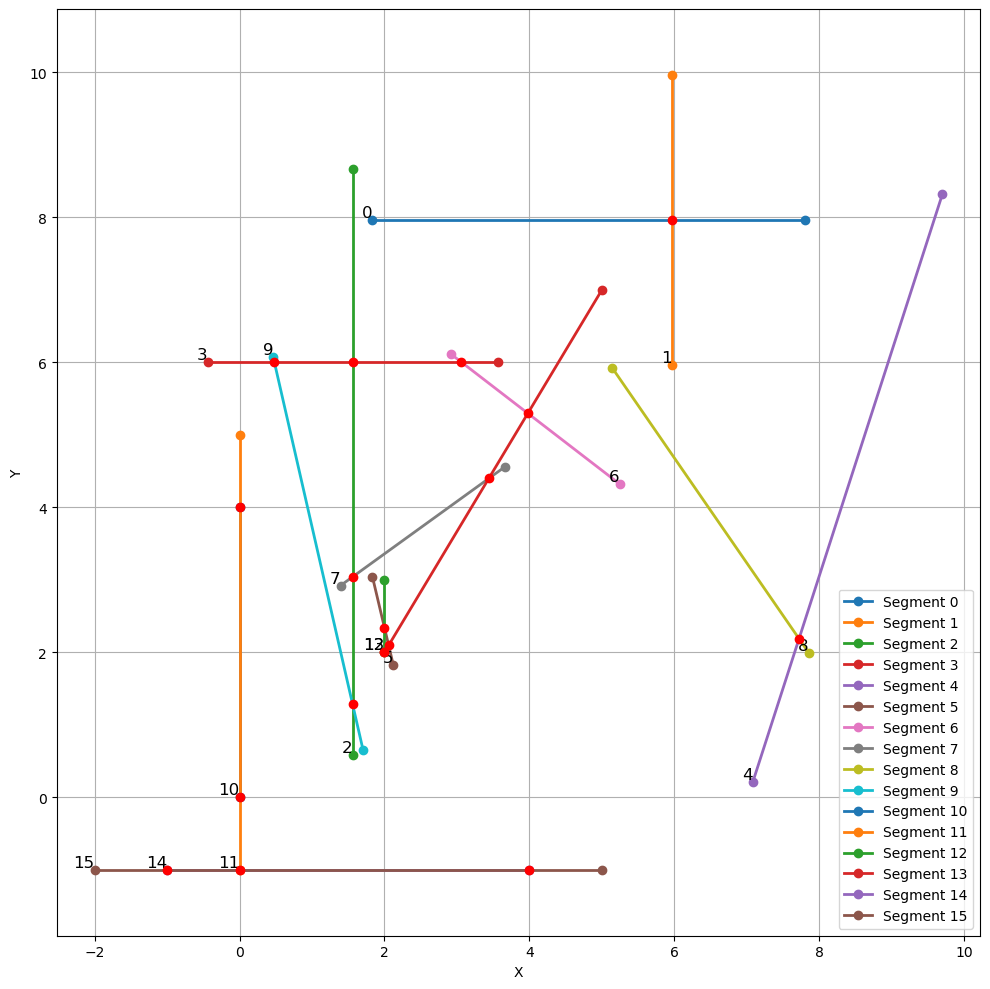

In [427]:
from matplotlib import pyplot as plt


class SegmentComparator:
    def __init__(self):
        self.event = Event(0, 0)
        self.is_above = True

    event: Event
    is_above: bool

    def find_segment_x(self, seg):
        return seg.start[0] + (seg.end[0] - seg.start[0]) * (self.event.y - seg.start[1]) / (seg.end[1] - seg.start[1]) \
            if abs(seg.end[1] - seg.start[1]) > 1e-9 else self.event.x

    def get_compare_value(self, seg: Segment):
        vy = seg.start[1] - seg.end[1]
        if abs(vy) < 1e-9:
            return -np.inf if self.is_above else np.inf
        vx = seg.start[0] - seg.end[0]
        res = vx / vy
        return res if self.is_above else -res

    def compare(self, seg1, seg2):
        if seg1.label == seg2.label:
            return 0
        seg1x = self.find_segment_x(seg1)
        seg2x = self.find_segment_x(seg2)
        if abs(seg1x - seg2x) > 1e-9:
            return seg1x - seg2x
        seg1_val = self.get_compare_value(seg1)
        seg2_val = self.get_compare_value(seg2)

        if seg1_val < seg2_val:
            return -1
        elif seg1_val == seg2_val:
            return seg1.label - seg2.label
        else:
            return 1


def find_segments_intersections(events_q, seg1, seg2, p):
    for point_arr in intersection_points(seg1, seg2):
        point = Event(point_arr[0], point_arr[1])
        if point.y < p.y or point.y == p.y and point.x > p.x:
            if point not in events_q:
                events_q.add(point)


def handle_event_point(p: Event, events_q: SortedList, seg_status: SortedList, labels_by_point,
                       comparator: SegmentComparator):
    start_in_p = p.start_in_this
    end_in_p = set()
    contain_p = set()
    dummy_seg = Segment(-1, np.array([[p.x, p.y + 1.0], [p.x, p.y - 1.0]]))
    comparator.is_above = True
    comparator.event = p
    index_to_search = seg_status.bisect_right(dummy_seg)
    if len(seg_status) > 0:
        for i in range(index_to_search - 1, -1, -1):
            if seg_status[i].end[0] == p.x and seg_status[i].end[1] == p.y:
                end_in_p.add(seg_status[i])
            elif point_on_segment(seg_status[i], p):
                contain_p.add(seg_status[i])
            else:
                break
        for i in range(index_to_search, len(seg_status)):
            if seg_status[i].end[0] == p.x and seg_status[i].end[1] == p.y:
                end_in_p.add(seg_status[i])
            elif point_on_segment(seg_status[i], p):
                contain_p.add(seg_status[i])
            else:
                break
    if len(start_in_p) + len(end_in_p) + len(contain_p) > 1:
        labels_by_point.append(([p.x, p.y], sorted([seg.label for seg in (start_in_p | end_in_p | contain_p)])))
    print(seg_status)
    for seg in (end_in_p | contain_p):
        print(seg, seg_status.bisect_right(seg), seg in seg_status)
        for s in seg_status:
            print(seg, s, comparator.compare(seg, s))
            print(comparator.find_segment_x(seg), comparator.find_segment_x(s),
                  comparator.get_compare_value(seg), comparator.get_compare_value(s))
        seg_status.remove(seg)
    comparator.is_above = False
    for seg in (start_in_p | contain_p):
        seg_status.add(seg)

    segments_sorted = SortedKeyList((start_in_p | contain_p), key=cmp_to_key(comparator.compare))
    index_to_search = seg_status.bisect_right(dummy_seg)
    if len(segments_sorted) == 0:
        if index_to_search < 1 or index_to_search == len(seg_status):
            return
        s_l = seg_status[index_to_search - 1]
        s_r = seg_status[index_to_search]
        find_segments_intersections(events_q, s_l, s_r, p)
    else:
        s1 = segments_sorted[0]
        s2 = segments_sorted[-1]
        s1_index = seg_status.index(s1)
        s2_index = seg_status.index(s2)
        if s1_index > 0:
            find_segments_intersections(events_q, seg_status[s1_index - 1], s1, p)
        if s2_index < len(seg_status) - 1:
            find_segments_intersections(events_q, s2, seg_status[s2_index + 1], p)


def find_intersections(segments_array):
    events_q = SortedList()
    comparator = SegmentComparator()
    seg_status = SortedKeyList(key=cmp_to_key(comparator.compare))
    segments = list()
    labels_by_point = list()
    for i, s in enumerate(segments_array):
        seg = Segment(i, s)
        segments.append(seg)
        beginning = Event(seg.start[0], seg.start[1])
        end = Event(seg.end[0], seg.end[1])
        if beginning not in events_q:
            events_q.add(beginning)
        if end not in events_q:
            events_q.add(end)
    for s in segments:
        start = s.start
        e = Event(start[0], start[1])
        if e in events_q:
            events_q[events_q.index(e)].start_in_this.add(s)
    while len(events_q) != 0:
        p = events_q.pop(0)
        handle_event_point(p, events_q, seg_status, labels_by_point, comparator)
    return labels_by_point


def plot_segments(segments, intersections_set):
    plt.figure(figsize=(10, 10))

    for i, seg in enumerate(segments):
        if i in intersections_set:
            plt.plot(seg[:, 0], seg[:, 1], marker='o', label=f'Segment {i}', linewidth=2)
        else:
            plt.plot(seg[:, 0], seg[:, 1], marker='o', label=f'Segment {i}', linewidth=2)
        x, y = seg[0]
        plt.text(x, y, f'{i}', fontsize=12, ha='right', va='bottom', color='black')


np.random.seed(42)
segments = generate_random_segments(n=10, min_intersections=2)
segments = np.append(segments, np.array(
    [
        [[0, 0], [0, 4]],
        [[0, -1], [0, 5]],
        [[2, 2], [2, 3]],
        [[2, 2], [5, 7]],
        [[-1, -1], [4, -1]],
        [[-2, -1], [5, -1]],
    ]
), axis=0)
# segments = np.array([segments[2],segments[3],segments[5],segments[7]])
intersections = find_intersections(segments)
plot_segments(segments, set())
for point, labels in intersections:
    print(labels)
    plt.scatter(point[0], point[1], color='r', zorder=4)
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')
plt.legend()
plt.tight_layout()
plt.show()
